In [ ]:
import os
import sys
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib.patches as mpatches
import nltk

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
train_df = pd.read_csv('../content/train.tsv', delimiter='\t', header = None)
valid_df = pd.read_csv('../content/valid.tsv', delimiter='\t', header = None)
test_df = pd.read_csv('../content/test.tsv', delimiter='\t', header = None)

In [ ]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [ ]:
def map_f(x):
    if x=='mostly-true' or x == 'true':
        return 0
    else:
        return 1
    
train = pd.DataFrame()
valid = pd.DataFrame()
test = pd.DataFrame()

train['text'] = train_df[2]
train['label'] = train_df[1].apply(map_f)

valid['text'] = valid_df[2]
valid['label'] = valid_df[1].apply(map_f)

test['text'] = train_df[2]
test['label'] = test_df[1].apply(map_f)

In [ ]:
len(train), len(valid), len(test)

(10240, 1284, 10240)

In [ ]:
X_train = pd.concat([train, valid])['text']
Y_train = pd.concat([train, valid])['label']
X_test = test['text']
Y_test = test['label']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of real and fake news')

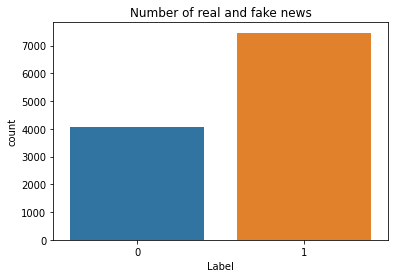

In [ ]:
sns.countplot(Y_train)
plt.xlabel('Label')
plt.title('Number of real and fake news')

In [ ]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
def LSTM_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = LSTM_model()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [ ]:
model.fit(sequences_matrix,Y_train,batch_size=50,epochs=20,validation_split=0.2)

Epoch 1/20
185/185 [==============================] - 19s 105ms/step - loss: 0.4157 - accuracy: 0.8094 - val_loss: 0.9312 - val_accuracy: 0.6260
Epoch 2/20
185/185 [==============================] - 19s 103ms/step - loss: 0.4034 - accuracy: 0.8149 - val_loss: 1.0520 - val_accuracy: 0.6130
Epoch 3/20
185/185 [==============================] - 19s 104ms/step - loss: 0.3889 - accuracy: 0.8182 - val_loss: 1.0339 - val_accuracy: 0.6195
Epoch 4/20
185/185 [==============================] - 20s 106ms/step - loss: 0.3791 - accuracy: 0.8223 - val_loss: 1.0851 - val_accuracy: 0.6369
Epoch 5/20
185/185 [==============================] - 19s 104ms/step - loss: 0.3646 - accuracy: 0.8307 - val_loss: 1.2243 - val_accuracy: 0.6169
Epoch 6/20
185/185 [==============================] - 19s 104ms/step - loss: 0.3475 - accuracy: 0.8365 - val_loss: 1.0707 - val_accuracy: 0.6161
Epoch 7/20
185/185 [==============================] - 19s 104ms/step - loss: 0.3361 - accuracy: 0.8426 - val_loss: 1.1258 - val_ac

In [ ]:
X_test = X_test[:1267]
Y_test = Y_test[:1267]

In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
y_pred = model.predict(test_sequences_matrix)
y_pred = y_pred.argmax(axis=-1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test.fillna(0), y_pred))

              precision    recall  f1-score   support

         0.0       0.35      1.00      0.52       449
         1.0       0.00      0.00      0.00       818

    accuracy                           0.35      1267
   macro avg       0.18      0.50      0.26      1267
weighted avg       0.13      0.35      0.19      1267



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
